In [1]:
import allium 
from allium import SimData
import glob 
import pickle 
import numpy as np
import matplotlib.pyplot as plt 

Cannot import zuko. Continuing without prior
No module named 'pycapmd'
Cannot import simulator


In [2]:
load_all =  True #load directly from a pickle
pre_separated = False #if three subfolders already exist for train test and val

override = False #make this true to always use the same ones

extension = "_open_ht_hv"
number_of_messages = 2
size_of_messages = 64
absolute = 0
epochs = 0
distrib = "laplace"

name_complete = extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative") + "_" + distrib

print(name_complete)

result_path = "models/result_recursive" + name_complete + "_" + str(epochs)
print(result_path)

_open_ht_hv_2_64_relative_laplace
models/result_recursive_open_ht_hv_2_64_relative_laplace_0


In [3]:
with open(result_path + ".pkl", "rb") as f:
    data_all = pickle.load(f)

In [4]:
data_y = data_all[0][1:] #model
data_x = data_all[1][1:] #data

In [5]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

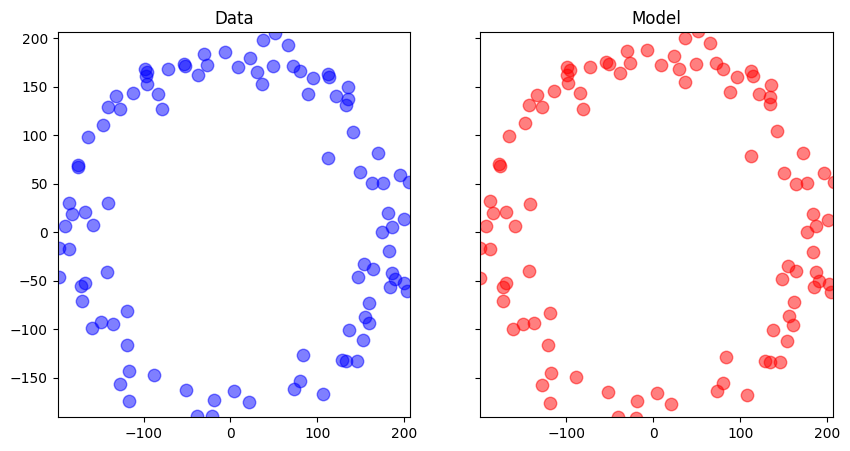

In [6]:
# Set up the figure and axis for the animation
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
sc_x = ax[0].scatter(data_x[0, :, 0], data_x[0, :, 1], s=80, c='b', alpha=0.5, label="True position")
sc_y = ax[1].scatter(data_y[0, :, 0], data_y[0, :, 1], s=80, c='r', alpha=0.5, label="Predicted position")


# Initialization function for the animation
def init():
    ax[0].set_xlim(np.min(data_x[:, :, 0]) - 1, np.max(data_x[:, :, 0]) + 1)
    ax[0].set_ylim(np.min(data_x[:, :, 1]) - 1, np.max(data_x[:, :, 1]) + 1)
    
    ax[1].set_xlim(np.min(data_x[:, :, 0]) - 1, np.max(data_x[:, :, 0]) + 1)
    ax[1].set_ylim(np.min(data_x[:, :, 1]) - 1, np.max(data_x[:, :, 1]) + 1)
    
    ax[0].set_title("Data")
    ax[1].set_title("Model")
    return sc_x, sc_y, 

# Update function for the animation
def update(frame):
    sc_x.set_offsets(data_x[frame, :, :2])

    sc_y.set_offsets(data_y[frame, :, :2])

    return sc_x, sc_y,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(97), init_func=init, blit=True, interval=30)

#save as gif
ani.save(result_path + "_animation.gif", writer="ffmpeg")

# Display the animation as a GIF in the Jupyter Notebook
HTML(ani.to_jshtml())

In [7]:
class Parameters(object):
    def __init__(self, p):
        for key, values in p.items():
            setattr(self, key, values)

class SyntheticData:
    @staticmethod
    def checkTypes(readtypes,data):
        #check which particles to load 
        if len(readtypes) > 0:
            usetypes = np.isin(data[:,-1],readtypes)
        else:
            usetypes = [True]*len(data)
        return usetypes

    # Data object for summary statistics
    def __init__(self,**kwargs):
        # check for debugging
        try:
            self.debug = kwargs['debug']
            if self.debug:
                print('kwargs: ', kwargs)
        except:
            self.debug = False
        # check for specific loadtimes
        try:    
            self.start = kwargs["loadtimes"][0]
            self.end = kwargs["loadtimes"][1]
            self.multiopt = True
        except:
            self.multiopt = False
        # check for specific types
        try:
            self.readtypes = kwargs["readtypes"]
        except:
            self.readtypes = []
            
        try:
            self.dt = kwargs["dt"]
        except:
            self.dt = 1
        # load parameters
        try:    
            self.param = Parameters(kwargs['params'])
        except Exception as e:
            print('Error! Parameters must be a dictionary', e)
            return 1
        # load multiple simulation snapshots
        self.Nsnap = self.end - self.start + 1
        #get maximum number of particles
        self.N = sum(SimData.checkTypes(self.readtypes, kwargs['data'][0]))
        self.Nvals = []
        self.Nvariable =  False
        for t in range(self.start,self.end):
            self.Nvals.append(sum(SimData.checkTypes(self.readtypes, kwargs['data'][t])))
            if self.Nvals[t] > self.N:
                self.N = self.Nvals[t] 
                self.Nvariable = True
        if kwargs['trackAll'] and self.Nvariable == False:
            self.Ntracers = self.Nvals[0]
        else:
            print('Error! Currently assuming tracking all cells')
        self.data = kwargs['data']
        print(self.data.shape[-1])
        self.flag = np.zeros((self.Nsnap,self.N))
        if self.data.shape[-1] == 5:
            self.Z = self.data[:,:,4]
        else:
            np.zeros((self.Nsnap,self.N))
            
        self.rval = self.data[:,:,:2]
        self.vval = self.data[:,:,2:4]
        self.theta = np.zeros((self.Nsnap,self.N))
        self.nval = np.zeros((self.Nsnap,self.N,2))
        self.radius = np.ones((self.Nsnap,self.N))
        self.ptype = np.ones((self.Nsnap,self.N))
        self.sigma = 0.
        
        return None

    def gettypes(self, readtypes, frames):
        return np.isin(self.ptype[frames],readtypes)

    def truncateto(self,start, endtime):
        self.Nsnap = endtime - start
        self.flag =  self.flag[start:endtime]
        self.rval = self.rval[start:endtime]
        self.vval = self.vval[start:endtime]
        self.theta = self.theta[start:endtime]
        self.nval = self.nval[start:endtime]
        self.radius = self.radius[start:endtime]
        self.ptype = self.ptype[start:endtime]
        self.Nvals = self.Nvals[start:endtime]
        self.Ntracers = self.Ntracers[start:endtime]


In [8]:
import json 

configfile = "simconfig_open.json"

with open(configfile) as jsonFile:
    parameters = json.load(jsonFile)

data = SyntheticData(loadtimes = [0,96], types = [0,1], debug = False, data = data_x, params = parameters, trackAll=True, dt = 1)


4


In [9]:
import allium.summstats as ss

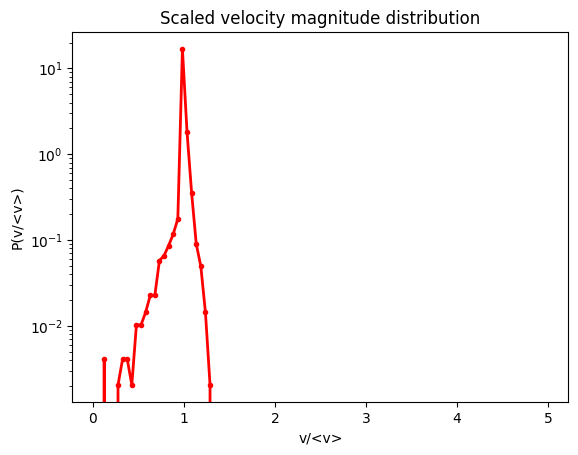

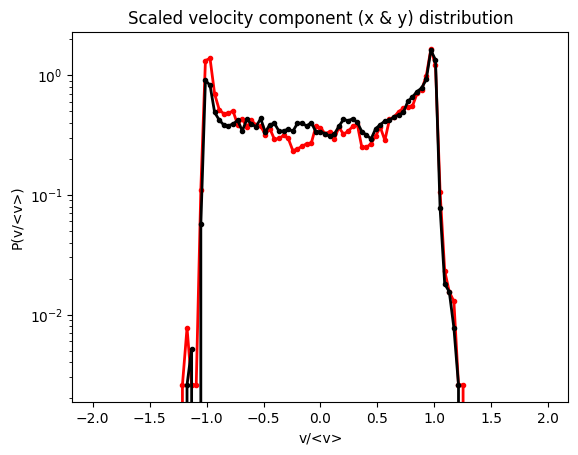

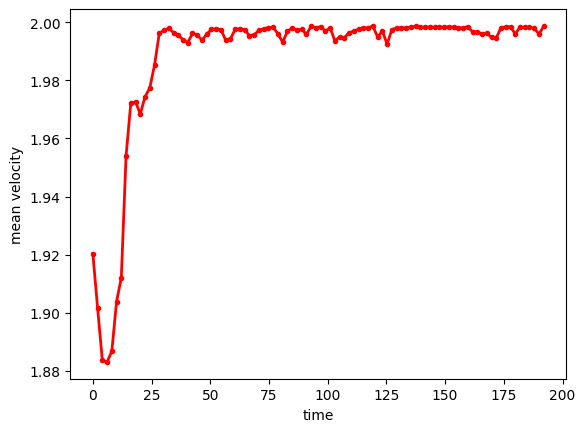

In [10]:
velbins=np.linspace(0,5,100)
velbins2=np.linspace(-2,2,100)
vav, vdist,vdist2 = ss.getVelDist(data, velbins,velbins2, usetype=[0,1],verbose=True)

vdist = vdist[1:]
vdist2 = vdist2[vdist2 != max(vdist2)]

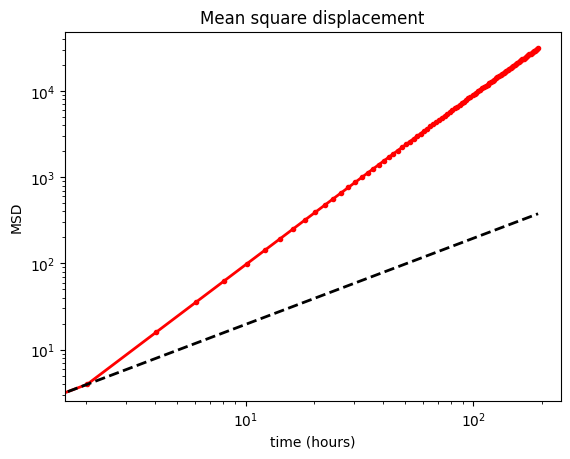

In [11]:
tval, msd, d = ss.getMSD(data, usetype=[1],verbose=True)

In [12]:
data = SyntheticData(loadtimes = [0,96], types = [0,1], debug = False, data = data_y, params = parameters, trackAll=True, dt = 1)

4


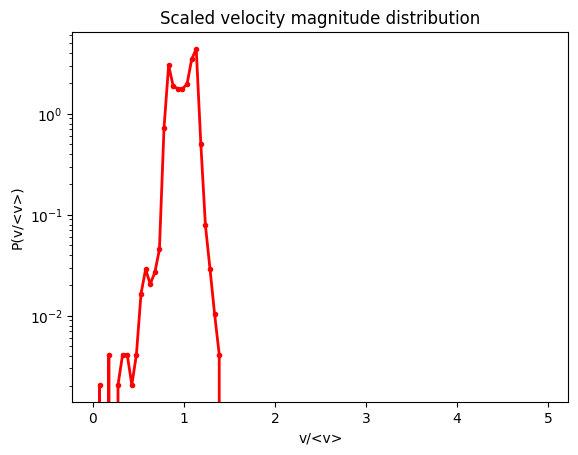

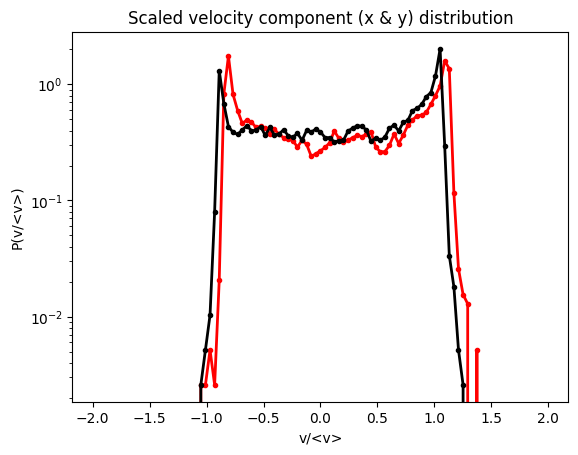

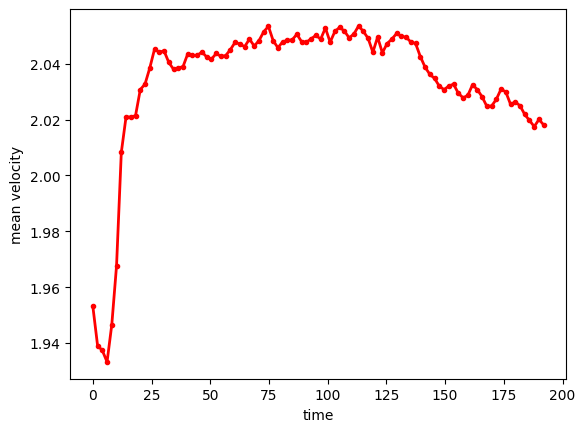

In [13]:
velbins=np.linspace(0,5,100)
velbins2=np.linspace(-2,2,100)
vav, vdist,vdist2 = ss.getVelDist(data, velbins,velbins2, usetype=[0,1],verbose=True)

vdist = vdist[1:]
vdist2 = vdist2[vdist2 != max(vdist2)]

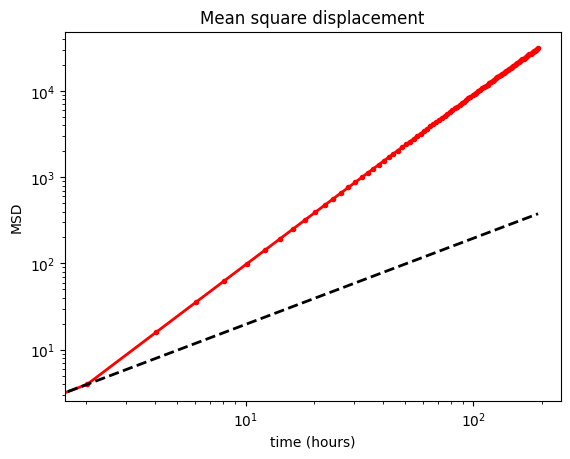

In [14]:
tval, msd, d = ss.getMSD(data, usetype=[1],verbose=True, periodic=False)